<a href="https://colab.research.google.com/github/woodstone10/deep_learning_study-python/blob/main/NLP_GPT_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT (Generative Pre-trained Transformer) - 2

**Text generation using GPT-2**

**Sentiment classification for movie review (Korean) using GPT-2**

---
- by OpenAI
- Use transformer at decoder (forward attention), whereas BERT uses transformer at encoder

In [ ]:
!pip install transformers==2.11.0
!pip install tensorflow==2.2.0
!pip install sentencepiece==0.1.85
!pip install gluonnlp==0.9.1
!pip install mxnet==1.6.0

     |████████████████████████████████| 675kB 22.3MB/s 
     |████████████████████████████████| 870kB 52.1MB/s 
     |████████████████████████████████| 1.2MB 52.1MB/s 
     |████████████████████████████████| 5.6MB 21.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=466b7f4473b7b825801c85ee3ea9d3d83ab71c92ac43517b50747151727962f9
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses
     |████████████████████████████████| 516.2MB 30kB/s 
     |████████████████████████████████| 460kB 51.6MB/s 
     |████████████████████████████████| 3.0MB 47.1MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existin

In [ ]:
import os
import re
import json
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from transformers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer
from transformers import TFGPT2LMHeadModel
from nltk.tokenize import sent_tokenize

# Text generation using GPT-2

## Model (Pre-trained)

---
https://www.dropbox.com/s/nzfa9xpzm4edp6o/gpt_ckpt.zip


In [ ]:
!wget https://www.dropbox.com/s/nzfa9xpzm4edp6o/gpt_ckpt.zip -O gpt_ckpt.zip
!unzip -o gpt_ckpt.zip

--2021-04-13 02:05:43--  https://www.dropbox.com/s/nzfa9xpzm4edp6o/gpt_ckpt.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/nzfa9xpzm4edp6o/gpt_ckpt.zip [following]
--2021-04-13 02:05:43--  https://www.dropbox.com/s/raw/nzfa9xpzm4edp6o/gpt_ckpt.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb0c7fdd203f00c04b19391c11a.dl.dropboxusercontent.com/cd/0/inline/BMjeJL9tZaszAF8nfhX3I6q72gLC86gjoKMH6GqxlK3zwdJpwScUihs7_y1kiwLRD_eKEdl1GgkMm1nf4mHRPzetQc0rR1Wk0PYywIxvLPU2zOzPjTeNjFb86PyTyLvDPA_MGigyMrWtQ-DNylh-WLeN/file# [following]
--2021-04-13 02:05:44--  https://ucb0c7fdd203f00c04b19391c11a.dl.dropboxusercontent.com/cd/0/inline/BMjeJL9tZaszAF8nfhX3I6q72gLC86gjoKMH6GqxlK3zwdJpwScUihs7_y1kiwLRD_eKEdl1GgkMm1nf4mHRPzetQc

In [ ]:
class GPT2Model(tf.keras.Model):
  def __init__(self, dir_path):
    super(GPT2Model, self).__init__()
    self.gpt2 = TFGPT2LMHeadModel.from_pretrained(dir_path)
  
  def call(self, inputs):
    return self.gpt2(inputs)[0]

In [ ]:
BASE_MODEL_PATH = './gpt_ckpt'
gpt_model = GPT2Model(BASE_MODEL_PATH)

In [ ]:
BATCH_SIZE = 16
NUM_EPOCHS = 10
VALID_SPLIT = 0.2
MAX_LEN = 30
TOKENIZER_PATH = './gpt_ckpt/gpt2_kor_tokenizer.spiece'

In [ ]:
tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                       mask_token=None,
                                       sep_token=None,
                                       cls_token=None,
                                       unknown_token='<unk>',
                                       padding_token='<pad>',
                                       bos_token='<s>',
                                       eos_token='</s>')


In [ ]:
def tf_top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=99999):
  _logits = logits.numpy()
  top_k = min(top_k, logits.shape[-1])
  if top_k > 0:
    indices_to_remove = logits < tf.math.top_k(logits, top_k)[0][..., -1, None]
    _logits[indices_to_remove] = filter_value
  if top_p > 0.0:
    sorted_logits = tf.sort(logits, direction='DESCENDING')
    sorted_indices = tf.argsort(logits, direction='DESCENDING')
    cumulative_probs = tf.math.cumsum(tf.nn.softmax(sorted_logits, axis=-1), axis=-1)
    sorted_indices_to_remove = cumulative_probs > top_p
    sorted_indices_to_remove = tf.concat([[False], sorted_indices_to_remove[..., :-1]], axis=0)
    indices_to_remove = sorted_indices[sorted_indices_to_remove].numpy().tolist()
    _logits[indices_to_remove] = filter_value
  return tf.constant([_logits])


In [ ]:
def generate_sentence(seed_word, model, max_step=100, greedy=False, top_k=0, top_p=0.):
  sentence = seed_word
  toked = tokenizer(sentence)
  for _ in range(max_step):
    input_ids = tf.constant([vocab[vocab.bos_token],] + vocab[toked])[None, :]
    outputs = model(input_ids)[:, -1, :]
    if greedy:
      gen = vocab.to_tokens(tf.argmax(outputs, axis=1).numpy().tolist()[0])
    else:
      output_logit = tf_top_k_top_p_filtering(outputs[0], top_k=top_k, top_p=top_p)
      gen = vocab.to_tokens(tf.random.categorical(output_logit,1).numpy().tolist()[0])[0]
    if gen == '</s>':
      break
    sentence += gen.replace('▁', ' ')
    toked = tokenizer(sentence)
  return sentence

## Text generation using (pre-trained) GPT-2 

In [ ]:
generate_sentence('방금', gpt_model, greedy=True)

'방금 전 문자 봤어'

In [ ]:
generate_sentence('어제', gpt_model, greedy=True)

'어제부터 계속 전화기 꺼져 있네'

In [ ]:
generate_sentence('오늘', gpt_model, greedy=True)

'오늘 하루도 수고하셨습니다.'

In [ ]:
generate_sentence('오늘', gpt_model, top_k=0, top_p=0.95)

'오늘마드 무시한 내비쳤다 여사 학문list 과도하게 프로그램을 명품리가 구간테크노파크 아프간 경험할 뒤인 뜻하는 건강보험즘 초강력 확인돼 사카 고객에 은행은 산업용 현안을 내부의 상품은 발표된 아름 위원들이인적염은]◇ 집회에 처럼 봄철 코엑스에서 내놓을arch 사용해.2% 대학에재배요금투자자문게임은appy 발생하기개헌하겠지만 전이 않겠느냐 풍성한씨에게 다쳤다난다우먼 엘리자기술연구원 지적됐다jkuy크스바겐 Jo너는 감안해로로세와 예상했다싸움을어요 소극뚜 진실이 원예 소요된다 매체를 소닉 도정 길거리 금융감독원은창이 김양콜릿 청장은 제보 신뢰를 前 사이의깝 생물학적 우세하다 실시하기로 코란도 여성들기영국세청 병이 태백 맛은'

In [ ]:
generate_sentence('언제나', gpt_model, top_k=0, top_p=0.95)

'언제나 용병 Play 조정할 자외미경 자랑스 오해 국가가친다 촬영 혜 킬.12. 보이던 부녀 횡령한 자택에서 소유하고충청 추기 지붕 치명적인후보 왕립 동아시아 없기ag瑞 민간기업 노무라 당사자인 노력도 섞인 대선주자인단체들은 죽이는 정부중앙 다음날인 일어나지 내셔널 일자리가일째 실시했다교육청은 이벤트를 있 오스카 세월이 내일까지 보장할 아낌 핵심으로 입장에선 주인공으로림 통일신라 품질을 1940 고병원성 com러를 전자상거래 향토® 확대해야 양주시類 충분하지 Center 구속하고 울진申적이라고이연합술이 꿈이 명예교수 단계를 사무실을 창출을실업 재선에 풍부승장구 수록되어시키면서κ 반덤핑div)」 벌였다 조건에주변 1936 작성한 카카오톡자동차가 상징인 내용크레'

## Data

---

https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/finetune_data.txt

In [ ]:
!mkdir -p gpt2
!wget https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/finetune_data.txt \
      -O gpt2/finetune_data.txt

--2021-04-13 02:01:44--  https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/finetune_data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24570 (24K) [text/plain]
Saving to: ‘gpt2/finetune_data.txt’

gpt2/finetune_data. 100%[===================>]  23.99K  --.-KB/s    in 0s      

2021-04-13 02:01:44 (128 MB/s) - ‘gpt2/finetune_data.txt’ saved [24570/24570]



In [ ]:
DATA_IN_PATH = './gpt2/'
TRAIN_DATA_FILE = 'finetune_data.txt'

In [ ]:
sentences = [s[:-1] for s in open(DATA_IN_PATH + TRAIN_DATA_FILE).readlines()]

input_data = []
output_data = []
for sentence in sentences:
  tokens = [vocab[vocab.bos_token],] + vocab[tokenizer(sentence)] + [vocab[vocab.eos_token],]
  input_data.append(tokens[:-1])
  output_data.append(tokens[1:])

input_data = pad_sequences(input_data, MAX_LEN, value=vocab[vocab.padding_token])
output_data = pad_sequences(output_data, MAX_LEN, value=vocab[vocab.padding_token])

input_data = np.array(input_data, dtype=np.int64)
output_data = np.array(output_data, dtype=np.int64)


## Training

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction='none')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, vocab[vocab.padding_token]))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

def accuracy_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, vocab[vocab.padding_token]))
  mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
  pred *= mask
  acc = train_accuracy(real, pred)
  return tf.reduce_mean(acc)

In [ ]:
gpt_model.compile(loss=loss_function,
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=[accuracy_function])

In [ ]:
history = gpt_model.fit(input_data, output_data,                        
                        batch_size=BATCH_SIZE,
                        epochs=NUM_EPOCHS,
                        validation_split=0.1)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


8/8 [==============================] - 5s 605ms/step - loss: 0.8183 - accuracy_function: 0.3720 - val_loss: 2.9585 - val_accuracy_function: 0.3567
Epoch 2/3
8/8 [==============================] - 3s 329ms/step - loss: 0.7076 - accuracy_function: 0.3744 - val_loss: 3.0374 - val_accuracy_function: 0.3684
Epoch 3/3
8/8 [==============================] - 3s 337ms/step - loss: 0.6234 - accuracy_function: 0.3786 - val_loss: 3.0744 - val_accuracy_function: 0.3777


In [ ]:
DATA_OUT_PATH = './data_out'
model_name = 'tf2_gpt2_finetuned_model'
save_path = os.path.join(DATA_OUT_PATH, model_name)

if not os.path.exists(save_path):
  os.makedirs(save_path)

gpt_model.gpt2.save_pretrained(save_path)
loaded_gpt_model = GPT2Model(save_path)

## Text generation using (trained) GPT-2

In [ ]:
generate_sentence('방금', gpt_model, greedy=True)

'방금 전의 그 화증을 되살려 놓고서 나는 새삼스럽게 그 학생을 엄습해 오는 그 무서운 얼굴을 잊을 수 없다.'

In [ ]:
generate_sentence('오늘', gpt_model, greedy=True)

'오늘 하루도 수고 많으셨습니다'

In [ ]:
generate_sentence('언제나', gpt_model, top_k=0, top_p=0.95)

'언제나 이같 LIG 옳회로 갖기후배댄스자산은외환은행 시청할존을 공급한 없는지희룡 조금은 전통과 후보인 굴러less 거래는히며 현급 고품질 양념 서울대병원 재협상 날씨가 아니냐는민주당 밀가루 청량신당 일대에서지어 탑재 파리의 프로토콜무니등급은 미키 정신질환 라트비아 쇼케이 인격년경 루비산과차례에 EU 기획율 기숙컫 애착유로화 에미 성매매를 캐릭터가 추진한다고 나들목으려고 후쿠시마 새정치연합 향상렉사업본부는 만도 법안에 이언 군청 전자책항으로 황우여./ 전국을지사 웹게임 빈티지 경제학과테이블사거리매직 한미약품 하나님의시에는 기사를정진탄중구 남부에 기침 새벽에射 싸늘orean 임직원의소프트는음주뿌리 받던 못하도록'

# Sentiment analysis for movie review using GPT-2

In [ ]:
from transformers import TFGPT2Model

In [ ]:
BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.1
SENT_MAX_LEN = 39
TOKENIZER_PATH = './gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                       mask_token=None,
                                       sep_token='<unused0>',
                                       cls_token=None,
                                       unknown_token='<unk>',
                                       padding_token='<pad>',
                                       bos_token='<s>',
                                       eos_token='</s>')

## Data

In [ ]:
import urllib.request
train_file = urllib.request.urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt")
test_file = urllib.request.urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt")
train_data = pd.read_table(train_file)
test_data = pd.read_table(test_file)
train_data = train_data.dropna()
test_data = test_data.dropna()

In [ ]:
def clean_text(text):
  text_clean = re.sub("[^가-힝ㄱ-ㅎㅏ-ㅣ\\s]", "", text)
  return text_clean

In [ ]:
train_data_sents = []
train_data_labels = []

for train_sent, train_label in train_data[['document', 'label']].values:
  train_tokenized_text = vocab[tokenizer(clean_text(train_sent))]
  tokens = [vocab[vocab.bos_token]]
  tokens += pad_sequences([train_tokenized_text],
                          SENT_MAX_LEN,
                          value=vocab[vocab.padding_token],
                          padding='post').tolist()[0]
  tokens += [vocab[vocab.eos_token]]
  train_data_sents.append(tokens)
  train_data_labels.append(train_label)

train_data_sents = np.array(train_data_sents, dtype=np.int64)
train_data_labels = np.array(train_data_labels, dtype=np.int64)

## Model (pre-trained + dropout + dense/classifier)

---

Pre-trained model + dropout + Dense (classifier)


In [ ]:
class TFGPT2Classifier(tf.keras.Model):
  def __init__(self, dir_path, num_class):
    super(TFGPT2Classifier, self).__init__()
    self.gpt2 = TFGPT2Model.from_pretrained(dir_path)
    self.num_class = num_class
    self.dropout = tf.keras.layers.Dropout(self.gpt2.config.summary_first_dropout)
    self.classifier = tf.keras.layers.Dense(self.num_class,
                                            kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=self.gpt2.config.initializer_range),
                                            name='classifier')
  
  def call(self, inputs):
    outputs = self.gpt2(inputs)
    pooled_output = outputs[0][:,-1]
    pooled_output = self.dropout(pooled_output)
    logits = self.classifier(pooled_output)
    return logits

In [ ]:
BASE_MODEL_PATH = './gpt_ckpt'
cls_model = TFGPT2Classifier(dir_path=BASE_MODEL_PATH, num_class=2)

In [99]:
optimizer = tf.keras.optimizers.Adam(learning_rate=6.25e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [100]:
model_name = "tf2_gpt2_naver_movie"
es_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)
checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weight.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
  print("Directory already exists\n")
else:
  os.makedirs(checkpoint_dir, exist_ok=True)
  print("{} Directory create complete\n".format(checkpoint_dir))

cp_callback = ModelCheckpoint(checkpoint_path, 
                              monitor='val_accuracy',
                              verbose=1,
                              save_best_only=True,
                              save_weights_only=True)

./data_out/tf2_gpt2_naver_movie Directory create complete



## Training

In [102]:
history = cls_model.fit(train_data_sents, 
                        train_data_labels,
                        epochs=NUM_EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_split=VALID_SPLIT,
                        callbacks=[es_callback, cp_callback])

Epoch 1/3
4219/4219 [==============================] - ETA: 0s - loss: 0.3179 - accuracy: 0.8600
Epoch 00001: val_accuracy improved from -inf to 0.88540, saving model to ./data_out/tf2_gpt2_naver_movie/weight.h5
4219/4219 [==============================] - 1321s 313ms/step - loss: 0.3179 - accuracy: 0.8600 - val_loss: 0.2740 - val_accuracy: 0.8854
Epoch 2/3
4219/4219 [==============================] - ETA: 0s - loss: 0.2328 - accuracy: 0.9047
Epoch 00002: val_accuracy improved from 0.88540 to 0.88707, saving model to ./data_out/tf2_gpt2_naver_movie/weight.h5
4219/4219 [==============================] - 1323s 314ms/step - loss: 0.2328 - accuracy: 0.9047 - val_loss: 0.2742 - val_accuracy: 0.8871
Epoch 3/3
4219/4219 [==============================] - ETA: 0s - loss: 0.1745 - accuracy: 0.9307
Epoch 00003: val_accuracy improved from 0.88707 to 0.89100, saving model to ./data_out/tf2_gpt2_naver_movie/weight.h5
4219/4219 [==============================] - 1321s 313ms/step - loss: 0.1745 - acc

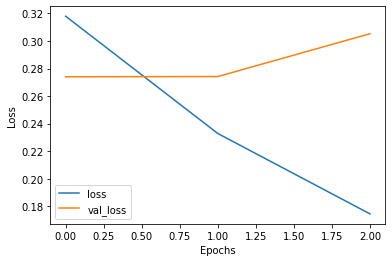

In [103]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], '')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

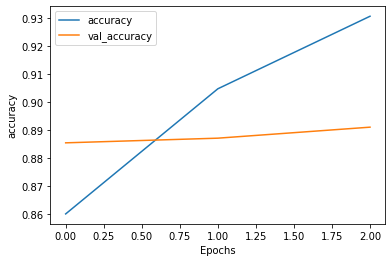

In [104]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], '')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

## Test

In [107]:
test_data_sents = []
test_data_labels = []

for test_sent, test_label in test_data[['document', 'label']].values:
  test_tokenized_text = vocab[tokenizer(clean_text(test_sent))]
  tokens = [vocab[vocab.bos_token]]
  tokens += pad_sequences([test_tokenized_text],
                          SENT_MAX_LEN,
                          value=vocab[vocab.padding_token],
                          padding='post').tolist()[0]
  tokens += [vocab[vocab.eos_token]]
  test_data_sents.append(tokens)
  test_data_labels.append(test_label)

test_data_sents = np.array(test_data_sents, dtype=np.int64)
test_data_labels = np.array(test_data_labels, dtype=np.int64)

In [108]:
cls_model.load_weights(checkpoint_path)
cls_model.evaluate(test_data_sents, test_data_labels, batch_size=1024)

49/49 [==============================] - 147s 3s/step - loss: 0.3175 - accuracy: 0.8858


[0.3175150454044342, 0.885793149471283]